In [5]:
import pygad
import numpy

function_inputs = [4,-2,3.5,5,-11,-4.7]
desired_output = 44

def fitness_func(solution, solution_idx):
    output = numpy.sum(solution*function_inputs)
    fitness = 1.0 / (numpy.abs(output - desired_output) + 0.000001)
    return fitness

fitness_function = fitness_func

def on_start(ga_instance):
    print("on_start()")

def on_fitness(ga_instance, population_fitness):
    print("on_fitness()")

def on_parents(ga_instance, selected_parents):
    print("on_parents()")

def on_crossover(ga_instance, offspring_crossover):
    print("on_crossover()")

def on_mutation(ga_instance, offspring_mutation):
    print("on_mutation()")

def on_generation(ga_instance):
    print("on_generation()")

def on_stop(ga_instance, last_population_fitness):
    print("on_stop()")

ga_instance = pygad.GA(num_generations=3,
                       num_parents_mating=5,
                       fitness_func=fitness_function,
                       sol_per_pop=10,
                       num_genes=len(function_inputs),
                       on_start=on_start,
                       on_fitness=on_fitness,
                       on_parents=on_parents,
                       on_crossover=on_crossover,
                       on_mutation=on_mutation,
                       on_generation=on_generation,
                       on_stop=on_stop)

ga_instance.run()

on_start()
on_fitness()
on_parents()
on_crossover()
on_mutation()
on_generation()
on_fitness()
on_parents()
on_crossover()
on_mutation()
on_generation()
on_fitness()
on_parents()
on_crossover()
on_mutation()
on_generation()
on_stop()


c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pygad\pygad.py:469: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pygad\pygad.py:486: UserWarning: The percentage of genes to mutate (mutation_percent_genes=5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))
c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pygad\pygad.py:731: UserWarning: Starting from PyGAD 2.6.0, the callback_generation parameter is deprecated and will be removed in a later release of PyGAD. Please use the on_generation parameter instead.
  

Generation = 1
Fitness    = 75.0
Change     = 75.0
Generation = 2
Fitness    = 75.0
Change     = 0.0
Generation = 3
Fitness    = 75.0
Change     = 0.0
Generation = 4
Fitness    = 100.0
Change     = 25.0
Generation = 5
Fitness    = 100.0
Change     = 0.0
Generation = 6
Fitness    = 100.0
Change     = 0.0
Generation = 7
Fitness    = 100.0
Change     = 0.0
Generation = 8
Fitness    = 100.0
Change     = 0.0
Generation = 9
Fitness    = 100.0
Change     = 0.0
Generation = 10
Fitness    = 100.0
Change     = 0.0
Generation = 11
Fitness    = 100.0
Change     = 0.0
Generation = 12
Fitness    = 100.0
Change     = 0.0
Generation = 13
Fitness    = 100.0
Change     = 0.0
Generation = 14
Fitness    = 100.0
Change     = 0.0
Generation = 15
Fitness    = 100.0
Change     = 0.0
Generation = 16
Fitness    = 100.0
Change     = 0.0
Generation = 17
Fitness    = 100.0
Change     = 0.0
Generation = 18
Fitness    = 100.0
Change     = 0.0
Generation = 19
Fitness    = 100.0
Change     = 0.0
Generation = 20
Fitnes

c:\Users\luisalves\WPy64-31050\python-3.10.5.amd64\lib\site-packages\pygad\pygad.py:3142: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


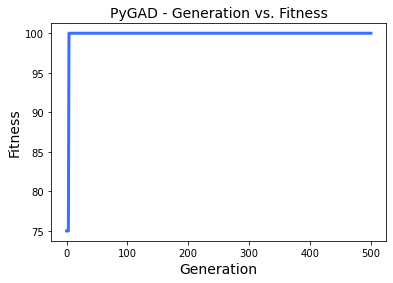

Parameters of the best solution : [ -5.48554844   1.79548804   0.63787612  -7.55539377   5.04581278
  -2.79037685 -12.16914024   1.88053206]
Fitness value of the best solution = 100.0
Index of the best solution : 0
Best fitness value reached after 4 generations.
Predictions of the trained network : [0, 1, 1, 0]
Number of correct classifications : 4.
Number of wrong classifications : 0.
Classification accuracy : 100.0.


In [1]:
import numpy
import pygad
import pygad.nn
import pygad.gann

def fitness_func(solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs)
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    solution_fitness = (correct_predictions/data_outputs.size)*100

    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks, 
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))

    last_fitness = ga_instance.best_solution()[1].copy()

# Holds the fitness value of the previous generation.
last_fitness = 0

# Preparing the NumPy array of the inputs.
data_inputs = numpy.array([[1, 1],
                           [1, 0],
                           [0, 1],
                           [0, 0]])

# Preparing the NumPy array of the outputs.
data_outputs = numpy.array([0, 
                            1, 
                            1, 
                            0])

# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = data_inputs.shape[1]
# The number of neurons in the output layer (i.e. number of classes).
num_classes = 2

# Creating an initial population of neural networks. The return of the initial_population() function holds references to the networks, not their weights. Using such references, the weights of all networks can be fetched.
num_solutions = 6 # A solution or a network can be used interchangeably.
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=num_inputs,
                                num_neurons_hidden_layers=[2],
                                num_neurons_output=num_classes,
                                hidden_activations=["relu"],
                                output_activation="softmax")

# population does not hold the numerical weights of the network instead it holds a list of references to each last layer of each network (i.e. solution) in the population. A solution or a network can be used interchangeably.
# If there is a population with 3 solutions (i.e. networks), then the population is a list with 3 elements. Each element is a reference to the last layer of each network. Using such a reference, all details of the network can be accessed.
population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
initial_population = population_vectors.copy()

num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.

num_generations = 500 # Number of generations.

mutation_percent_genes = 5 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "single_point" # Type of the crossover operator.

mutation_type = "random" # Type of the mutation operator.

keep_parents = 1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

init_range_low = -2
init_range_high = 5

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       callback_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Predicting the outputs of the data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                               data_inputs=data_inputs)
print("Predictions of the trained network : {predictions}".format(predictions=predictions))

# Calculating some statistics
num_wrong = numpy.where(predictions != data_outputs)[0]
num_correct = data_outputs.size - num_wrong.size
accuracy = 100 * (num_correct/data_outputs.size)
print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))